In [306]:
#ML Framework Stuff:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Image Import Commands: 
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

In [307]:
#Path. EDIT based upon computer in use
folder_testicular = "./testicular_cancer/"
proteint_annot_testicular = "./metadata/testicular/mdanderson.org_TGCT.MDA_RPPA_Core.antibody_annotation.txt"
TCGA_annot_testicular = "./metadata/testicular/mdanderson.org_TGCT.MDA_RPPA_Core.sdrf.txt"
image_path = "./TCGA_Labels.png"
patient_info_testicular = "./metadata/testicular/nationwidechildrens.org_clinical_patient_tgct.txt"

folder_cervical = "./cervical_cancer/"
proteint_annot_cervical = "./metadata/cervical/mdanderson.org_CESC.MDA_RPPA_Core.antibody_annotation.txt"
TCGA_annot_cervical = "./metadata/cervical/mdanderson.org_CESC.MDA_RPPA_Core.sdrf.txt"
patient_info_cervical = "./metadata/cervical/nationwidechildrens.org_clinical_patient_cesc.txt"

In [308]:
#How much patient data do we have? 
folder = folder_testicular
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} Files".format(len(onlyfiles)))

Working with 123 Files


In [309]:
#Explore one data entry
data = pd.read_csv(folder + onlyfiles[1], sep="\t",header=None)
data.columns = ["Protein", "Protein_Expression"]
data.head()

,Protein,Protein_Expression
0,Sample REF,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF
1,Composite Element REF,Protein Expression
2,14-3-3_beta-R-V,-0.0335156857500001
3,14-3-3_epsilon-M-C,0.09775616625
4,14-3-3_zeta-R-V,0.13591790775


In [310]:
counter = 0
for names in onlyfiles: 
    if names == '.DS_Store':
        print("bad")
    else: 
        new_data = pd.read_csv(folder + names, sep="\t",header=None)
        new_data.columns = ["Protein", "Protein_Expression"]
        data= data.merge(new_data,left_on='Protein',right_on="Protein")
    counter = counter +1   

print(str(counter))
print("The shape of the data frame is: " + str(data.shape))

bad
123
The shape of the data frame is: (220, 124)


In [311]:
data = data.drop(1,axis=0)
data = data.T

In [312]:
protein_annotations = pd.read_csv(proteint_annot_testicular, sep="\t",header=None)
protein_annotations = protein_annotations.drop(protein_annotations.columns[[1,3,4,5,6,7,8]],axis = 1)
protein_annotations = protein_annotations.T
protein_annotations.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C


In [313]:
data_with_genes =  pd.merge(protein_annotations.T, data.T, left_on=2, right_on='Protein')
data_with_genes = data_with_genes.T
data_with_genes = data_with_genes.drop("Protein", axis=0)
data_with_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025
Protein_Expression_y,3A6A2C20-768D-44A6-9A60-8E06B938C7DD,0.07353710625,-0.0102309167499999,0.00777842375000004,-0.03335799075,0.10784540625,0.42195591525,0.18469539025,-0.39719495725,-0.0702879402499999,...,0.08875102275,-0.40576595925,0.20232167925,0.16949194925,-0.02762927475,-0.08810751125,-0.58564213825,0.41443317775,0.50069445975,0.19707753125
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025


In [314]:
TCGA_Annot = pd.read_csv(TCGA_annot_testicular,sep="\t",header=None)
TCGA_Annot = TCGA_Annot[[4,9]]

In [315]:
data_with_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025
Protein_Expression_y,3A6A2C20-768D-44A6-9A60-8E06B938C7DD,0.07353710625,-0.0102309167499999,0.00777842375000004,-0.03335799075,0.10784540625,0.42195591525,0.18469539025,-0.39719495725,-0.0702879402499999,...,0.08875102275,-0.40576595925,0.20232167925,0.16949194925,-0.02762927475,-0.08810751125,-0.58564213825,0.41443317775,0.50069445975,0.19707753125
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025


In [316]:
data_genes_TCGA =  pd.merge(data_with_genes,TCGA_Annot , left_on=0, right_on=4,how='left')
data_genes_TCGA = data_genes_TCGA.drop_duplicates()

In [317]:
#Get all column names
cols = list(data_genes_TCGA)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('9_y')))
# use ix to reorder
data_genes_TCGA = data_genes_TCGA.loc[:, cols]
data_genes_TCGA = data_genes_TCGA.drop("4_y", axis=1)

In [318]:
#Final Reorganization Steps
data_genes_TCGA = data_genes_TCGA.reset_index()
data_genes_TCGA = data_genes_TCGA.drop(data_genes_TCGA.columns[[0]],axis = 1)
data_genes_TCGA.columns = range(data_genes_TCGA.shape[1])
data_genes_TCGA.shape

(124, 220)

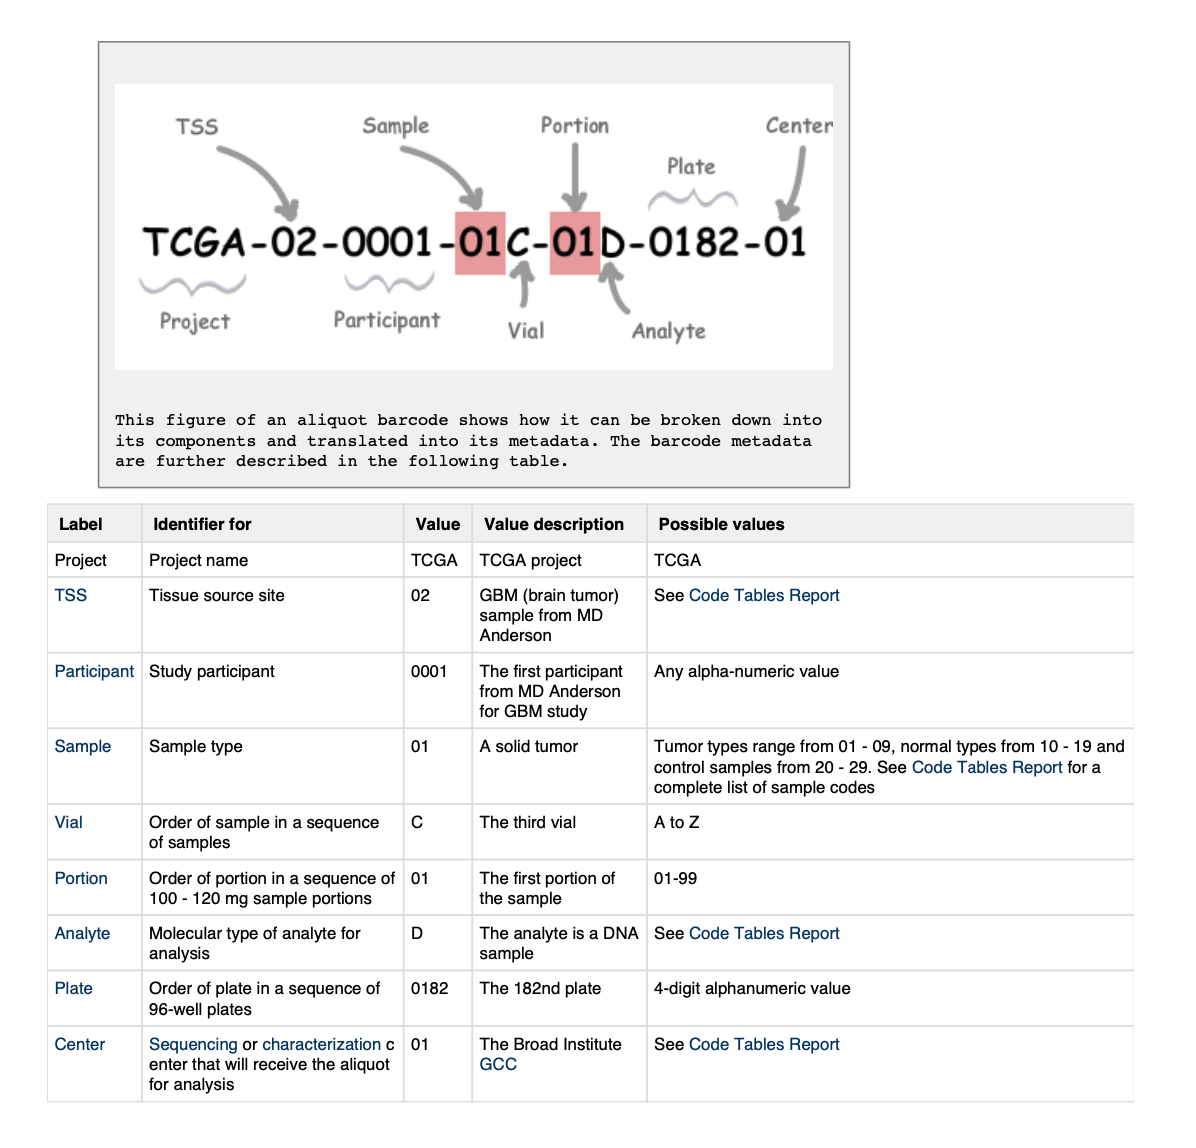

In [319]:
#The TCGA ID of column zero is made up of the following portions: 
from IPython.display import Image
Image(image_path)

In [320]:
data_genes_TCGA["PatientID_1"]= data_genes_TCGA.insert(0,'Patient_ID',data_genes_TCGA[0].astype(str).str[0:12])

In [321]:
data_genes_TCGA = data_genes_TCGA.drop("PatientID_1",axis=1)

In [322]:
#Time to Merge in the Patient Data: 
Patient_Info = pd.read_csv(patient_info_testicular,sep="\t",header=None)
# 
# Patient_Info = Patient_Info.drop([0,2,3,4,7],axis=1)
Patient_Info = Patient_Info [[1,5,6,22,23,46,47,70,76,87]] #This is choosing the features to add from the metadata. Change if needed.
Patient_Info = Patient_Info.drop([0,1,2],axis=0)

Patient_Info.head()

#Below is are the features being kept:
#Patient ID, Race, Ethnicity, Tumor Status, Vital Status, AJCC Nodes Pathologic pn, AJCC Tumor Pathologic Pt
#,age at diagnosis, Gender,Tissue source site

,1,5,6,22,23,46,47,70,76,87
3,TCGA-2G-AAEW,WHITE,NOT HISPANIC OR LATINO,WITH TUMOR,Dead,N0,M0,31,MALE,Testes
4,TCGA-2G-AAEX,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,38,MALE,Testes
5,TCGA-2G-AAF1,ASIAN,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes
6,TCGA-2G-AAF4,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,30,MALE,Testes
7,TCGA-2G-AAF6,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes


In [323]:
data_genes_TCGA_patient =  pd.merge(Patient_Info, data_genes_TCGA, right_on="Patient_ID", left_on=1,how='right')
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([1],axis=1)

In [324]:
index = np.arange(start=0, stop=107, step=1)
index2 = [107,108]
index3 = np.arange(109,124,1)
indexi = np.concatenate((np.concatenate((index2, index)),index3))

data_genes_TCGA_patient = data_genes_TCGA_patient.reindex(indexi) 


In [325]:
data_genes_TCGA_patient = data_genes_TCGA_patient.reset_index()
data_genes_TCGA_patient.columns = range(data_genes_TCGA_patient.shape[1])

In [326]:
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([0,1],axis=1)
testicular_cancer_db = data_genes_TCGA_patient

In [327]:
#Drop all patients for which there is no metadata. Reduces Patient size to 108
testicular_cancer_db = testicular_cancer_db.drop(np.arange(109,124,1),axis=0)

In [329]:
testicular_cancer_db.shape

(109, 230)

# Cervical Cancer Data Preperation: 

In [363]:
#How much patient data do we have? 
folder = folder_cervical
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} Files".format(len(onlyfiles)))

Working with 173 Files


In [364]:
#Explore one data entry
data = pd.read_csv(folder + onlyfiles[1], sep="\t",header=None)
data.columns = ["Protein", "Protein_Expression"]
data.head()

,Protein,Protein_Expression
0,Sample REF,9F4623A9-D7C2-4EB5-8CA9-6F0C67828AEB
1,Composite Element REF,Protein Expression
2,14-3-3_beta-R-V,-0.0961422259999999
3,14-3-3_epsilon-M-C,0.0479013300000001
4,14-3-3_zeta-R-V,0.169819278


In [365]:
counter = 0
for names in onlyfiles: 
    if names == '.DS_Store':
        print("bad")
    else: 
        new_data = pd.read_csv(folder + names, sep="\t",header=None)
        new_data.columns = ["Protein", "Protein_Expression"]
        data= data.merge(new_data,left_on='Protein',right_on="Protein")
    counter = counter +1   

print(str(counter))
print("The shape of the data frame is: " + str(data.shape))

173
The shape of the data frame is: (221, 175)


In [366]:
data = data.drop(1,axis=0)
data = data.T

In [367]:
protein_annotations = pd.read_csv(proteint_annot_cervical, sep="\t",header=None)
protein_annotations = protein_annotations.drop(protein_annotations.columns[[1,3,4,5,6,7,8]],axis = 1)
protein_annotations = protein_annotations.T

In [368]:
data_with_genes =  pd.merge(protein_annotations.T, data.T, left_on=2, right_on='Protein')
data_with_genes = data_with_genes.T
data_with_genes = data_with_genes.drop("Protein", axis=0)

In [369]:
TCGA_Annot = pd.read_csv(TCGA_annot_cervical,sep="\t",header=None)
TCGA_Annot = TCGA_Annot[[4,9]]

In [370]:
data_genes_TCGA =  pd.merge(data_with_genes,TCGA_Annot , left_on=0, right_on=4,how='left')
data_genes_TCGA = data_genes_TCGA.drop_duplicates()

In [371]:
#Get all column names
cols = list(data_genes_TCGA)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('9_y')))
# use ix to reorder
data_genes_TCGA = data_genes_TCGA.loc[:, cols]
data_genes_TCGA = data_genes_TCGA.drop("4_y", axis=1)

In [372]:
#Final Reorganization Steps
data_genes_TCGA = data_genes_TCGA.reset_index()
data_genes_TCGA = data_genes_TCGA.drop(data_genes_TCGA.columns[[0]],axis = 1)
data_genes_TCGA.columns = range(data_genes_TCGA.shape[1])

In [373]:
data_genes_TCGA["PatientID_1"]= data_genes_TCGA.insert(0,'Patient_ID',data_genes_TCGA[0].astype(str).str[0:12])
data_genes_TCGA = data_genes_TCGA.drop("PatientID_1",axis=1)
data_genes_TCGA.head()

,Patient_ID,0,1,2,3,4,5,6,7,8,...,211,212,213,214,215,216,217,218,219,220
0,nan,NaN,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,nan,NaN,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,TCGA-IR-A3LK,TCGA-IR-A3LK-01A-21-A40I-20.P,9F4623A9-D7C2-4EB5-8CA9-6F0C67828AEB,-0.0961422259999999,0.0479013300000001,0.169819278,-0.075831038,0.038788279,-1.127755122,-0.198689621,...,-0.00122411699999997,0.039628302,0.0490967589999999,0.110302646,0.0508761200000001,0.03616566,0.218577961,0.293310549,-0.136349382,-0.268227368
3,TCGA-HG-A9SC,TCGA-HG-A9SC-01A-11-A40I-20.P,6F7ABE28-0E7B-48F7-9713-F18E9D295340,0.312821002,0.155283895,2.065443593,0.612668201,0.0691699790000002,-0.389325492,0.723970018,...,0.652668032,-1.151127237,0.664127639,1.091521267,0.624802454,1.010854939,-0.288773081,0.693003233,-0.554225848,-0.0282948159999998
4,TCGA-MY-A913,TCGA-MY-A913-01A-21-A40H-20.P,263D2292-E1D0-4937-90C2-C733495AFF02,0.0991454460000001,-0.173895199,0.157127898,-0.125666103,0.403258985,0.344101951,0.00911584700000001,...,-0.020927656,-0.138491186,0.685017796,0.159698137,0.030697672,-0.441736308,-0.123092341,0.449807231,0.69125433,0.519572406


In [374]:
#Time to Merge in the Patient Data: 
Patient_Info = pd.read_csv(patient_info_cervical,sep="\t",header=None) 
Patient_Info = Patient_Info [[1,6,10,14,25,52,63,67,84,143]]
Patient_Info = Patient_Info.drop([1,2],axis=0)
Patient_Info.head()

# Selecting: 
#gender,race, vital_status, tumor_status, age_at_diagnosis, tumor_grade, ajcc_nodes_pathologic_pn
#ajcc_tumor_pathologic_pt, tissue_source_site

,1,6,10,14,25,52,63,67,84,143
0,bcr_patient_barcode,gender,race,vital_status,tumor_status,age_at_diagnosis,tumor_grade,ajcc_nodes_pathologic_pn,ajcc_tumor_pathologic_pt,tissue_source_site
3,TCGA-2W-A8YY,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,2W
4,TCGA-4J-AA1J,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,4J
5,TCGA-BI-A0VR,FEMALE,WHITE,Alive,TUMOR FREE,53,G3,N1,T2b,BI
6,TCGA-BI-A0VS,FEMALE,WHITE,Alive,TUMOR FREE,48,G3,N0,T1b1,BI


In [375]:
data_genes_TCGA_patient =  pd.merge(Patient_Info, data_genes_TCGA, right_on="Patient_ID", left_on=1,how='right')
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([1],axis=1)

,1_x,6_x,10_x,14_x,25_x,52_x,63_x,67_x,84_x,143_x,...,211,212,213,214,215,216,217,218,219,220
0,TCGA-2W-A8YY,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,2W,...,0.838128249,-1.204358576,0.98026583,0.576061552,0.742962649,0.280943847,-0.427620815,-1.555734871,-0.519747159,-0.0442280939999999
1,TCGA-4J-AA1J,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,4J,...,0.0805494759999999,-0.253046523,0.942242258,-0.114616487,0.016992148,-0.434624842,-0.144857264,0.507210703,-0.140891075,-0.499351567
2,TCGA-C5-A0TN,FEMALE,BLACK OR AFRICAN AMERICAN,Dead,WITH TUMOR,21,G3,N1,T1b,C5,...,0.263113133,-0.733918136,0.745076229,0.0438304549999999,0.416370827,-0.130751658,-0.765478521,-0.140173625,-0.269787991,-0.582786817
3,TCGA-C5-A1BJ,FEMALE,WHITE,Alive,TUMOR FREE,34,G2,[Not Available],[Not Available],C5,...,0.149026925,-1.175232736,0.385511914,0.108417951,0.21380467,-0.289599716,-0.809573713,0.377003716,0.058947844,0.244777088
4,TCGA-C5-A1BL,FEMALE,WHITE,Alive,TUMOR FREE,32,G2,[Not Available],[Not Available],C5,...,-0.0127822510000001,0.231920047,-0.0807587360000004,0.0806445969999999,0.0738671730000001,0.501761702,0.465701617,0.131480934,0.401168342,0.271057336
5,TCGA-C5-A1M5,FEMALE,WHITE,Dead,WITH TUMOR,53,G2,N0,T1b,C5,...,-0.084053787,0.018828912,-0.136913201,0.147198091,-0.26154668,0.00380331800000006,0.268117565,-0.079437045,-0.322177906,-0.018790652
6,TCGA-C5-A1M6,FEMALE,WHITE,Dead,WITH TUMOR,55,G3,[Not Available],[Not Available],C5,...,-0.015841175,-0.1176332,0.0841888689999999,0.009455043,0.080863133,-0.287112516,-0.601944208,-0.256867193,0.00492427500000009,0.16162096
7,TCGA-C5-A1M7,FEMALE,WHITE,Alive,TUMOR FREE,37,G2,N0,T1b,C5,...,0.304353975,-1.395724713,1.057175583,0.418929367,0.200809203,0.00434749300000004,-0.834175382,0.237766165,0.498659538,0.093031522
8,TCGA-C5-A1M8,FEMALE,WHITE,Alive,TUMOR FREE,43,G2,N0,T1b,C5,...,-0.096630975,0.265972925,-0.320026794,-0.125114019,-0.144011031,-0.123779679,0.227795779,0.16695718,0.561559933,0.408950375
9,TCGA-C5-A1M9,FEMALE,WHITE,Dead,WITH TUMOR,46,G3,N1,T3b,C5,...,-0.0217896989999998,0.225278191,0.775808279,-0.34531877,-0.0690524809999997,0.0982376960000002,0.238949862,0.60746483,-0.428432164,-0.327260146


In [376]:
index = np.arange(start=0, stop=173, step=1)
index2 = [173,174]
index3 = np.arange(174,175,1)
indexi = np.concatenate((np.concatenate((index2, index)),index3))
data_genes_TCGA_patient = data_genes_TCGA_patient.reindex(indexi) 


In [377]:
data_genes_TCGA_patient = data_genes_TCGA_patient.reset_index()
data_genes_TCGA_patient.columns = range(data_genes_TCGA_patient.shape[1])
data_genes_TCGA_patient.head()

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,229,230,231,232
0,173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,0,TCGA-2W-A8YY,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,...,0.838128249,-1.204358576,0.98026583,0.576061552,0.742962649,0.280943847,-0.427620815,-1.555734871,-0.519747159,-0.0442280939999999
3,1,TCGA-4J-AA1J,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,...,0.0805494759999999,-0.253046523,0.942242258,-0.114616487,0.016992148,-0.434624842,-0.144857264,0.507210703,-0.140891075,-0.499351567
4,2,TCGA-C5-A0TN,FEMALE,BLACK OR AFRICAN AMERICAN,Dead,WITH TUMOR,21,G3,N1,T1b,...,0.263113133,-0.733918136,0.745076229,0.0438304549999999,0.416370827,-0.130751658,-0.765478521,-0.140173625,-0.269787991,-0.582786817


In [378]:
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([0,1],axis=1)
cervical_cancer_db = data_genes_TCGA_patient
cervical_cancer_db = cervical_cancer_db.drop([175],axis=0)

In [379]:
#Wahoo. Now ready for the SVD
cervical_cancer_db.head()

,2,3,4,5,6,7,8,9,10,11,...,223,224,225,226,227,228,229,230,231,232
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,2W,TCGA-2W-A8YY,...,0.838128249,-1.204358576,0.98026583,0.576061552,0.742962649,0.280943847,-0.427620815,-1.555734871,-0.519747159,-0.0442280939999999
3,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,4J,TCGA-4J-AA1J,...,0.0805494759999999,-0.253046523,0.942242258,-0.114616487,0.016992148,-0.434624842,-0.144857264,0.507210703,-0.140891075,-0.499351567
4,FEMALE,BLACK OR AFRICAN AMERICAN,Dead,WITH TUMOR,21,G3,N1,T1b,C5,TCGA-C5-A0TN,...,0.263113133,-0.733918136,0.745076229,0.0438304549999999,0.416370827,-0.130751658,-0.765478521,-0.140173625,-0.269787991,-0.582786817


In [ ]:
#Adding features from patient side (BASIC) is finished

#Next: Solve the missing proteing problem

#Decide which features we are gonna try to group, then run SVD and see if we can quantify any results. 
#Furthermore, need some basis, to prove the data is normal. perhaps find a protein which typically overexpressed
#In both types of cancer or in males and females. If that doesn't work....unsure. 

#I've removed all data for which we don't have any metadata shrinking the number of males. Females have more
#patchy data. Will have to remove on a case by case basis. 

## SVD:  

In [167]:
#Select the expression values only: 
cerv_data = cervical_cancer_db.iloc[2:,8:]
tes_data = testicular_cancer_db.iloc[2:,5:]

#Convert to numpy array 
cerv_array = cerv_data.values
tes_array = tes_data.values

In [168]:
print("The shape of is " + str(cerv_array.shape))
print("Total number of cervical patients: " + str(cerv_array.shape[0]))
print("Total number of cervical features: " + str(cerv_array.shape[1]))

print()
print("The shape of is " + str(tes_array.shape))
print("Total number of testicular patients: " + str(tes_array.shape[0]))
print("Total number of testicular features: " + str(tes_array.shape[1]))

The shape of is (173, 219)
Total number of cervical patients: 173
Total number of cervical features: 219

The shape of is (122, 218)
Total number of testicular patients: 122
Total number of testicular features: 218


In [169]:
#Questions to answer: do the SVD, find the missing protein causing the difference in length, remove all patients 
#for which we don't have meta data (gender etc). Exists in both males and females

#Testicular appears to have 218 genes
#Ovarian appears to have 219 genes BOTH CONFIRMED FROM ORIGINAL DATA
#Patient numbers are equal. 
#The question still remains what is the misssing protein


In [170]:
cerv_array

array([['0.879446109', '0.283619534', '0.795979302', ..., '-1.555734871',
        '-0.519747159', '-0.0442280939999999'],
       ['0.153368761', '-0.11355863', '0.258062906', ..., '0.507210703',
        '-0.140891075', '-0.499351567'],
       ['0.123183488', '-0.03426341', '0.313855226', ..., '-0.140173625',
        '-0.269787991', '-0.582786817'],
       ...,
       ['1.154726379', '-0.622469291', '0.31579234', ..., '-0.368411531',
        '2.189381174', '-0.696829229'],
       ['0.140824075', '0.199997195', '0.353947477', ..., '-0.140014159',
        '0.337417984', '-0.0624450320000001'],
       ['-0.260754296', '-0.331246859', '-0.162688343', ...,
        '0.190780213', '0.239166302', '-0.00232083200000011']],
      dtype=object)

In [171]:
#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
cerv_test = np.array(list(cerv_array[:, :]), dtype=np.float)
tes_test = np.array(list(tes_array[:, :]), dtype=np.float)

In [182]:
from scipy.linalg import svd
U_cerv,sigma_cerv,VT_cerv = svd(cerv_test,full_matrices=False)
U_tes,sigma_tes,VT_tes = svd(tes_test,full_matrices=False)

In [183]:
print("Shape of U cervical " + str(U_cerv.shape))
sigma_cerv = np.diag(sigma_cerv) 
print("Shape of Sigma cervical" + str(sigma_cerv.shape))
print("Shape of VT cervical" + str(VT_cerv.shape))

print("\nShape of U cervical " + str(U_tes.shape))
sigma_tes = np.diag(sigma_tes) 
print("Shape of Sigma testicular" + str(sigma_tes.shape))
print("Shape of VT testicular" + str(VT_tes.shape))

Shape of U cervical (173, 173)
Shape of Sigma cervical(173, 173)
Shape of VT cervical(173, 219)

Shape of U cervical (122, 122)
Shape of Sigma testicular(122, 122)
Shape of VT testicular(122, 218)


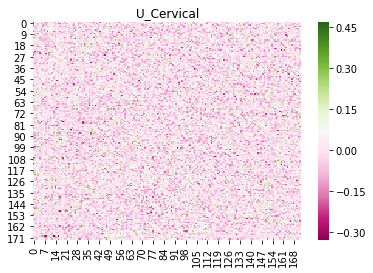

In [189]:
#Let's Visualize Heatmaps....

#Starting with U!
ax = sns.heatmap(U_cerv,cmap = "PiYG")
plt.title("U_Cervical")
plt.show()

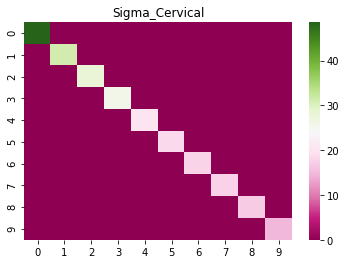

In [194]:
#Starting with sigma
ax = sns.heatmap(sigma_cerv[0:10,0:10],cmap = "PiYG")
plt.title("Sigma_Cervical")
plt.show()

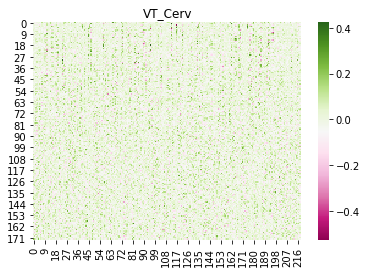

In [195]:
#Starting with sigma
ax = sns.heatmap(VT_cerv,cmap = "PiYG")
plt.title("VT_Cerv")
plt.show()

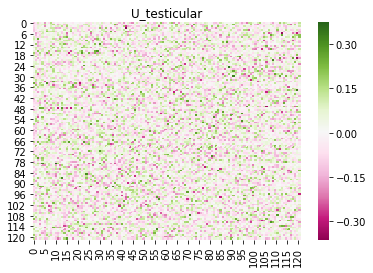

In [197]:
#Starting with U!
ax = sns.heatmap(U_tes,cmap = "PiYG")
plt.title("U_testicular")
plt.show()

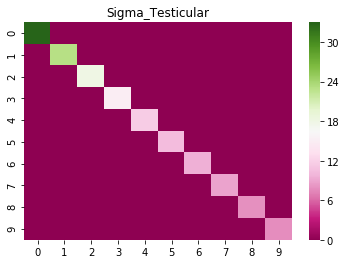

In [198]:
#Sigma
ax = sns.heatmap(sigma_tes[0:10,0:10],cmap = "PiYG")
plt.title("Sigma_Testicular")
plt.show()

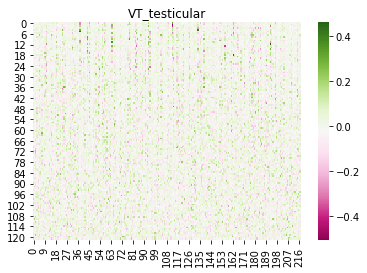

In [199]:
#Starting with VT!
ax = sns.heatmap(VT_tes,cmap = "PiYG")
plt.title("VT_testicular")
plt.show()

In [ ]:
#Alright. Time to go back to the dataframes. Let's add all the metadata that I think might effect something. 
#Then from each of those arrays, I will organize the data from those points. 

# This is me overthinking stufff

In [174]:
#data = data.drop(1,axis=0)
#data.rename(columns={'Protein':'one'}, 
#                 index={0:'zero',1:'one'}, 
#                 inplace=True)

#new_header = data.iloc[0] #grab the first row for the header
#row = data['one']
#new = data[0:] #take the data less the header row
#new.columns = new_header #set the header row as the df header
#new = new.set_index(row)
#new = new.drop(columns = "Sample REF")
#new = new.drop("Sample REF",axis=0)

#new.head()

In [ ]:
#new = new.T
#new.head()

In [ ]:
#new.rename(columns={ new.columns[0]: "Patient" })